In [103]:
import pandas as pd
import seaborn as sns
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [104]:
data = pd.read_csv('../data/laptops.csv').drop(['Unnamed: 0', 'img_link'], axis=1)
data.shape

(984, 10)

### missing values

In [105]:
data.isna().sum()*100/data.shape[0]

name                 0.000000
price(in Rs.)        0.000000
processor            0.000000
ram                  0.000000
os                   0.000000
storage              0.000000
display(in inch)     0.000000
rating              30.081301
no_of_ratings       30.081301
no_of_reviews       30.081301
dtype: float64

In [106]:
data[~data['rating'].isna()].isna().sum()

name                0
price(in Rs.)       0
processor           0
ram                 0
os                  0
storage             0
display(in inch)    0
rating              0
no_of_ratings       0
no_of_reviews       0
dtype: int64

- The same records have missing values for rating, no_of_ratings and no_of_reviews columns
- I am going to impute the missing values with negative one. Meaning if there is a missing rating then the rating is -1 and the number of ratings will be -1 and also the number of reviews will be negative one

In [107]:
data.fillna(-1, inplace=True)

### duplicates

In [108]:
data.duplicated().sum()

212

- We have 212 records duplicated. These records will not add any value to out analysis. I will therefore drop them

In [109]:
data.drop_duplicates(keep='first', inplace=True)

In [110]:
data.shape

(772, 10)

In [111]:
def to_lower(text: str)->str:
    return str(text).lower()

text_columns = ['name', 'processor', 'ram', 'storage', 'os']
for col in text_columns:
    data[col] = data[col].apply(to_lower)

### column names

In [112]:
data.rename(columns={'price(in Rs.)': 'price_in_rs', 'display(in inch)': 'display_in_inch'}, inplace=True)

In [129]:
list(data.columns)

['price_in_rs',
 'os',
 'display_in_inch',
 'rating',
 'no_of_ratings',
 'no_of_reviews',
 'laptop',
 'processor_manufacturer',
 'processor_generation',
 'number_of_cores',
 'ram_in_gb',
 'storage_type',
 'primary_storage_size']

## name

- checking if name column has repeatitions

In [114]:
len(data['name'].unique()) == data.shape[0]

False

In [115]:
data[['name', 'price_in_rs']]\
    .groupby('name')\
    .count()\
    .sort_values(by='price_in_rs')\
    .shape

(498, 1)

The name column cannot be used as an id column because it contains repeatitions

In [116]:
data['laptop'] = data['name'].str.split(expand=True)[0]

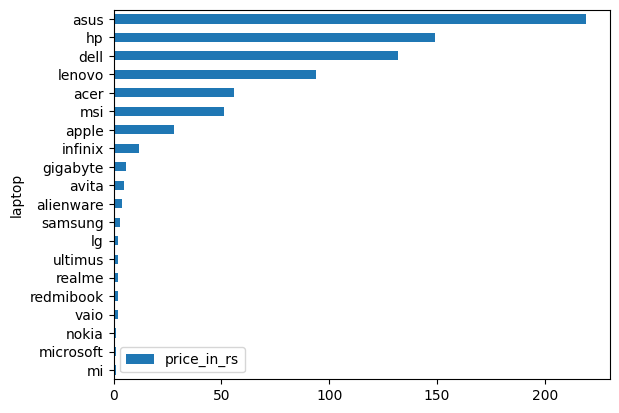

In [117]:
data[['laptop', 'price_in_rs']]\
    .groupby('laptop')\
    .count()\
    .sort_values(by='price_in_rs')\
    .plot(kind='barh');

In [118]:
del data['name']

### processor

In [119]:
def extract_processor(processor: str)->list:
    processor_split = processor.split()
    processor_manufacturer = processor_split[0]
    if 'intel' in processor:
        if any([i in processor  for i in ['pentium', 'celeron']]):
            processor_generation = 1
            number_of_cores = 2 if 'dual' in processor else 4
        else:
            
            processor_generation = processor.split('(')[-1].split()[0].replace('th', '')

            core_index = processor_split.index('core')+1
            number_of_cores = processor_split[core_index].replace('i', '')
    elif 'amd' in processor:
        if '(' in processor:
            processor_generation = processor.split('(')[-1].split()[0].replace('th', '')
        else:
            processor_generation = 1
        if 'dual' in processor:
            number_of_cores = 2
        elif 'quad' in processor:
            number_of_cores = 4
        elif 'hexa' in processor:
            number_of_cores = 6
        elif 'octa' in processor:
            number_of_cores = 8
        else:
            number_of_cores = 1
    elif 'apple' in processor:
        processor_generation = 1 if '1' in processor else 2
        number_of_cores = 8
    else:
        processor_manufacturer, processor_generation, number_of_cores = np.nan, np.nan, np.nan
            
    return [processor_manufacturer, processor_generation, number_of_cores]

In [120]:
data['processor_manufacturer'] = data['processor'].apply(lambda t: extract_processor(t)[0])
data['processor_generation'] = data['processor'].apply(lambda t: extract_processor(t)[1])
data['number_of_cores'] = data['processor'].apply(lambda t: extract_processor(t)[1])

In [121]:
data.isna().sum()

price_in_rs               0
processor                 0
ram                       0
os                        0
storage                   0
display_in_inch           0
rating                    0
no_of_ratings             0
no_of_reviews             0
laptop                    0
processor_manufacturer    2
processor_generation      2
number_of_cores           2
dtype: int64

In [122]:
data.dropna(inplace=True)
del data['processor']

## ram

In [123]:
data['ram_in_gb'] = data['ram'].str.split(expand=True)[0]
del data['ram']

### storage 

In [124]:
data['storage_type'] = data['storage']\
                .apply(
                    lambda x: 
                        str(x).split()[-1] if '|' not in x 
                        else f"{str(x).split('|')[0].split()[-1]} {str(x).split('|')[1].split()[-1]}"
                    )

def calculate_storage_size(storage: str)->int:
    storage_split = str(storage).split()
    try:
        labeled_size = int(storage_split[0])
    except:
        labeled_size = np.nan
        print(storage)
    labeled_tag = storage_split[1]
    if labeled_tag=='gb':
        return labeled_size
    elif labeled_tag=='tb':
        return labeled_size*1000

data['primary_storage_size'] = data['storage'].apply(calculate_storage_size)

del data['storage']
data.dropna(inplace=True)

pci-e ssd (nvme) ready,silver-lining print keyboard,matrix display (extend),cooler boost 5,hi-res audio,nahimic 3,144hz panel,thin bezel,rgb gaming keyboard,speaker tuning engine,msi center
pci-e gen4 ssd?shift?matrix display (extend)?cooler boost 3?thunderbolt 4?finger print security?true color 2.0?hi-res audio?nahimic 3? 4-sided thin bezel?msi center?silky smooth touchpad?military-grade durability


### os

In [125]:
data['os'].unique()

array(['windows 11 operating system',
       '64 bit windows 11 operating system', 'dos operating system',
       'mac os operating system', '64 bit windows 10 operating system',
       '32 bit windows 11 operating system', 'chrome operating system',
       '64 bit chrome operating system', 'windows 10 operating system',
       '64 bit dos operating system', '64 bit windows 8 operating system'],
      dtype=object)

### save the clean data

In [126]:
data.to_csv('../data/clean_laptops.csv', index=False)
data.shape

(768, 13)